# Example of source with multiple channels


In [4]:
import configparser
import os.path
from alpenglow.s3_image_source import S3ImageSource

path_format = '/skin660_488_reflectance/skin{stripe_id:01d}/skin{stripe_id:01d}_{version_id:05d}.tif'
stripe_ids = [1, 2, 3]
version_ids = [1, 512, 1024, 1536, 2048, 2560, 3072, 3584]

config_parser = configparser.ConfigParser()
config_parser.read_file(open(os.path.join(os.path.expanduser('~'), '.aws', 'credentials')))
config_parser.sections()

aws_access_key_id = config_parser.get('default', 'AWS_ACCESS_KEY_ID')
aws_secret_access_key = config_parser.get('default', 'AWS_SECRET_ACCESS_KEY')

def image_mapping(stripe_id, version_id):
    return (stripe_id, version_id if stripe_id % 2 == 1 else 4201 - version_id)

image_source = S3ImageSource(path_format, stripe_ids, version_ids, aws_access_key_id, aws_secret_access_key, 'alpenglowoptics', 'https://s3.amazonaws.com', mapping=image_mapping, channel_count=2)
print("configuration read")

configuration read


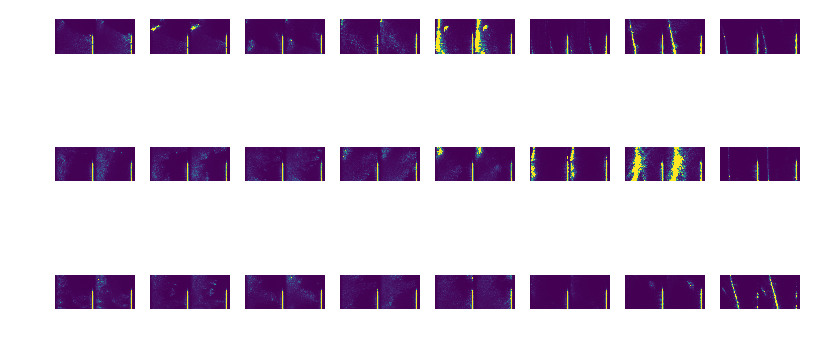

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import concurrent

fig = plt.figure(figsize=(8, 4), dpi=120)

version_count = image_source.version_count()
stripe_count = image_source.stripe_count()

future_to_position = {}
for stripe_id in range(stripe_count):
    stripe = image_source.get_stripe(stripe_id)
    for version_id in range(version_count):
        future_to_position[stripe.get_channel_image_future(version_id, 0)] = 1 + version_id + version_count * stripe_id
        
for future in concurrent.futures.as_completed(future_to_position):
    position = future_to_position[future]
    try:
        data = future.result()
        ax = fig.add_subplot(stripe_count, version_count, position)
        ax.imshow(data)
        ax.set_axis_off()
    except Exception as exc:
        print('%r generated an exception: %s' % (position, exc))